In [2]:
from helmholtz_exact import DielectricHankelCoefficients, U_tot_from_coefficients, U_tot_from_coefficients_conducting, HankelWave, float_array, complex_array, ConductingHankelCoefficients
import numpy as np
from scipy.constants import c
import matplotlib.pyplot as plt 
from matplotlib.patches import Circle, Rectangle, Polygon

import cvxpy as cp

from scipy.special import hankel1

from scipy.spatial.distance import jaccard
from numpy.typing import NDArray
from numpy.linalg import svd
from numpy import hypot
from scipy.special import j0, y0

def H_01(r: float_array) -> complex_array:
    return j0(r) + 1j*y0(r)

float_array = NDArray[np.float64]
complex_array = NDArray[np.complex128]



In [79]:
N_E = 36
N_R = 72
N_M = 3

theta_E = np.linspace(0, 2*np.pi, N_E, endpoint=False)
theta_R = np.linspace(0, 2*np.pi, N_R, endpoint=False)

R_E = 0.72
R_R = 0.76

r_E = R_E*np.column_stack((np.cos(theta_E), np.sin(theta_E)))
r_R = R_R*np.column_stack((np.cos(theta_R), np.sin(theta_R)))
f = 8*1E9 # 1 GHz
k = 2*np.pi*f/c
NUMBER_OF_MODES = 20
U = 1 + 0j
sx = 0.
sy = 0.030 # 30 mm 
s = np.array([sx, sy])
R = 0.015 # 15 mm

eps_r = 3.00

Text(0.5, 0.98, 'Near field matrix for f = 8.0 GHz')

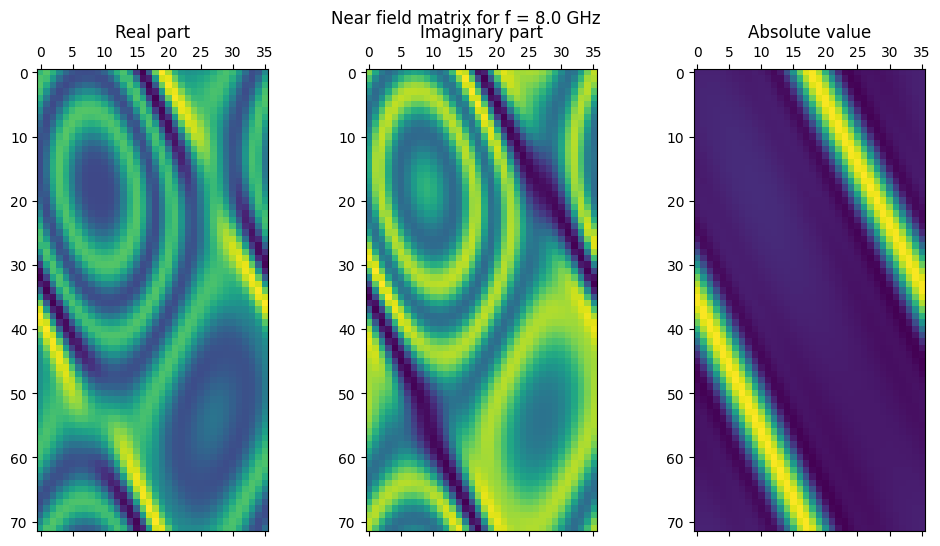

In [80]:
NF = np.zeros((N_R, N_E), dtype=np.complex128)

conducting = True
if conducting:
    for e in range(N_E):
        A = ConductingHankelCoefficients(k, R, s, U, r_E[e,:], NUMBER_OF_MODES)
        U_inc = HankelWave(r_R[:,0], r_R[:,1], k, sx, sy, U)
        NF[:,e] = U_tot_from_coefficients_conducting(r_R[:,0], r_R[:,1], k, s, R, U, U_inc, A) - U_inc 
else:
    for e in range(N_E):
        A, B = DielectricHankelCoefficients(k, eps_r, R, s, U, r_E[e,:], NUMBER_OF_MODES)
        U_inc = HankelWave(r_R[:,0], r_R[:,1], k, sx, sy, U)
        NF[:,e] = U_tot_from_coefficients(r_R[:,0], r_R[:,1], k, eps_r, s, R, U, U_inc, A, B) - U_inc 



fig, ax = plt.subplots(ncols=3, figsize=(12,6))
ax[0].matshow(np.real(NF))
ax[0].set_title('Real part')
ax[1].matshow(np.imag(NF))
ax[1].set_title('Imaginary part')

ax[2].matshow(np.abs(NF))
ax[2].set_title('Absolute value')
fig.suptitle(f'Near field matrix for f = {f/1E9 :.1f} GHz')

In [81]:
# NF_cropped = np.full((N_R, N_E), dtype=np.complex128, fill_value=np.nan + 1j*np.nan)
# r_ID = np.zeros((N_M, N_E), dtype=np.int32)
# N_blocked = N_R - N_M
# for e in range(N_E):
#     r_ID[:,e] = ( ( N_blocked - 1 ) // 2  + np.arange(N_M) + 2*e ) % N_R
#     NF_cropped[r_ID[:,e],e] = NF[r_ID[:,e],e] 

# NF_zeros= np.zeros((N_R, N_E), dtype=np.complex128)
# N_blocked = N_R - N_M
# for e in range(N_E):
#     NF_zeros[r_ID[:,e],e] = NF[r_ID[:,e],e] 



# fig, ax = plt.subplots(ncols=3, figsize=(12,6))
# ax[0].matshow(np.real(NF_cropped))
# ax[0].set_title('Real part')
# ax[1].matshow(np.imag(NF_cropped))
# ax[1].set_title('Imaginary part')

# ax[2].matshow(np.abs(NF_cropped))
# ax[2].set_title('Absolute value')
# fig.suptitle(f'Near field matrix, cropped,  for f = {f/1E9 :.1f} GHz')

Text(0.5, 0.98, 'Near field matrix, cropped,  for f = 8.0 GHz')

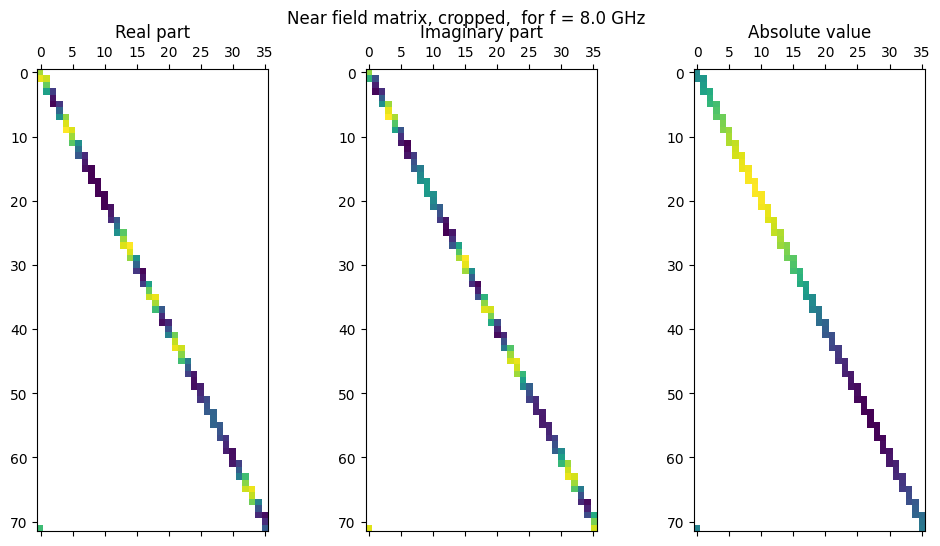

In [82]:
NF_cropped = np.full((N_R, N_E), dtype=np.complex128, fill_value=np.nan + 1j*np.nan)
r_ID = np.zeros((N_M, N_E), dtype=np.int32)
N_blocked = N_R - N_M
for e in range(N_E):
    r_ID[:,e] = ( ( np.arange(N_M) + 2*e  - (N_M-1)//2 ) % N_R )
    NF_cropped[r_ID[:,e],e] = NF[r_ID[:,e],e] 

NF_zeros= np.zeros((N_R, N_E), dtype=np.complex128)
N_blocked = N_R - N_M
for e in range(N_E):
    NF_zeros[r_ID[:,e],e] = NF[r_ID[:,e],e] 



fig, ax = plt.subplots(ncols=3, figsize=(12,6))
ax[0].matshow(np.real(NF_cropped))
ax[0].set_title('Real part')
ax[1].matshow(np.imag(NF_cropped))
ax[1].set_title('Imaginary part')

ax[2].matshow(np.abs(NF_cropped))
ax[2].set_title('Absolute value')
fig.suptitle(f'Near field matrix, cropped,  for f = {f/1E9 :.1f} GHz')

Text(0.5, 0.98, 'Near field matrix, zeroed,  for f = 8.0 GHz')

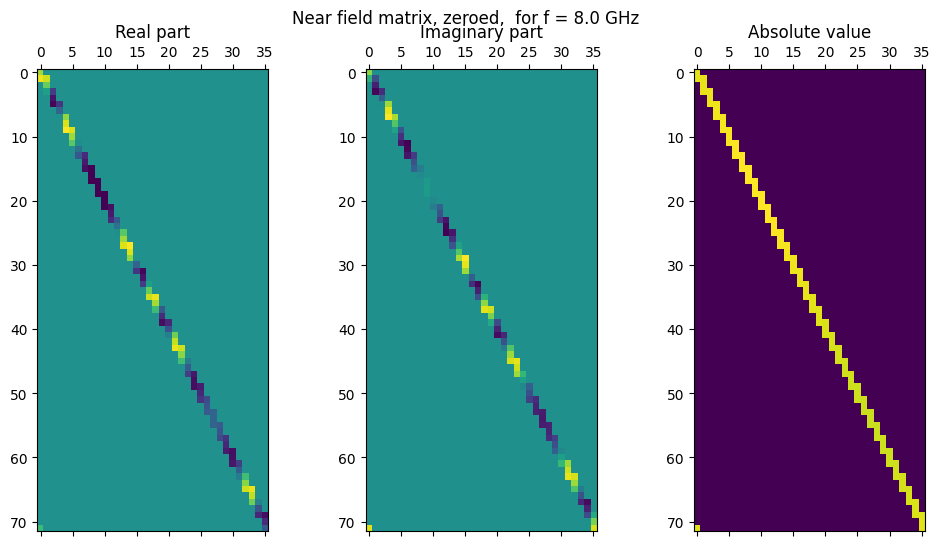

In [83]:
fig, ax = plt.subplots(ncols=3, figsize=(12,6))
ax[0].matshow(np.real(NF_zeros))
ax[0].set_title('Real part')
ax[1].matshow(np.imag(NF_zeros))
ax[1].set_title('Imaginary part')

ax[2].matshow(np.abs(NF_zeros))
ax[2].set_title('Absolute value')
fig.suptitle(f'Near field matrix, zeroed,  for f = {f/1E9 :.1f} GHz')

In [84]:
# NF_Fresnel = np.zeros((N_M, N_E), dtype=np.complex128)
# N_blocked = N_R - N_M
# for e in range(N_E):
#     NF_Fresnel[:,e] = NF[r_ID[:,e],e] 

# fig, ax = plt.subplots(ncols=3, figsize=(12,6))
# ax[0].matshow(np.real(NF_Fresnel))
# ax[0].set_title('Real part')
# ax[1].matshow(np.imag(NF_Fresnel))
# ax[1].set_title('Imaginary part')

# ax[2].matshow(np.abs(NF_Fresnel))
# ax[2].set_title('Absolute value')
# fig.suptitle(f'Near field matrix as Fresnel, for f = {f/1E9 :.1f} GHz')

Text(0.5, 0.98, 'Near field matrix as Fresnel, for f = 8.0 GHz')

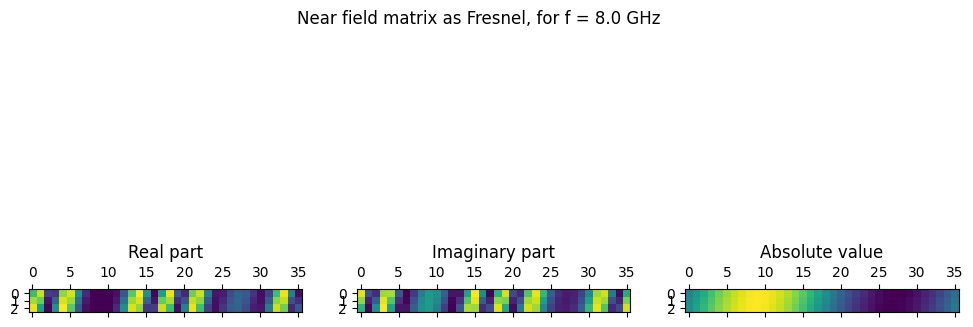

In [85]:
NF_Fresnel = np.zeros((N_M, N_E), dtype=np.complex128)
N_blocked = N_R - N_M
for e in range(N_E):
    NF_Fresnel[:,e] = NF[r_ID[:,e],e] 

fig, ax = plt.subplots(ncols=3, figsize=(12,6))
ax[0].matshow(np.real(NF_Fresnel))
ax[0].set_title('Real part')
ax[1].matshow(np.imag(NF_Fresnel))
ax[1].set_title('Imaginary part')

ax[2].matshow(np.abs(NF_Fresnel))
ax[2].set_title('Absolute value')
fig.suptitle(f'Near field matrix as Fresnel, for f = {f/1E9 :.1f} GHz')

# Fourier extrapolation

In [86]:
def Fourier_Matrix( theta : float_array, M : int) -> complex_array:
    """Returns the fourier interpolating matrix"""
    n = np.arange(-M, M+1)
    FM = np.exp(1j*np.outer(theta,n))
    return FM

def approx_solve(A : complex_array, b: complex_array, alpha : np.float64) -> complex_array:
    """Computes: 
    argmin ||Ax - b||^2 + alpha ||x||^2"""
    u, sigma, vh = np.linalg.svd(A, full_matrices=False)
    x =  np.transpose(np.conjugate(vh))*(sigma/(sigma**2+alpha)) @ np.transpose(np.conjugate(u)) @ b
    return x 

def Fourier_extrapolate( theta : float_array, x : complex_array) -> complex_array:
    M = (len(x) - 1 ) // 2
    FM_extrapolate = Fourier_Matrix(theta, M)
    u = np.dot(FM_extrapolate,x)
    return u

In [87]:
FOURIER_MODES = 5

e = 9

FM = Fourier_Matrix(theta_R[r_ID[:,e]], FOURIER_MODES)

alpha = 0.01
u_exact = NF[r_ID[:,e],e]
err = 5e-3
if err == 0:
    noise = 0
    StN = "∞"
else:
    noise = err * np.linalg.norm(u_exact)*(np.random.rand(*u_exact.shape) + 1j*np.random.rand(*u_exact.shape))
    StN = 1/err

u_noisy = u_exact + noise
x = approx_solve( A=FM, b=u_noisy, alpha=alpha)
u = Fourier_extrapolate(theta_R,x)

Text(0.5, 1.0, 'Fourier extrapolation for f = 8.0 GHz,\n$\\theta_\\mathrm{inc}=90.0^\\circ$, $\\alpha=0.01$, $\\mathrm{StN}=200.0$\n and 5 modes')

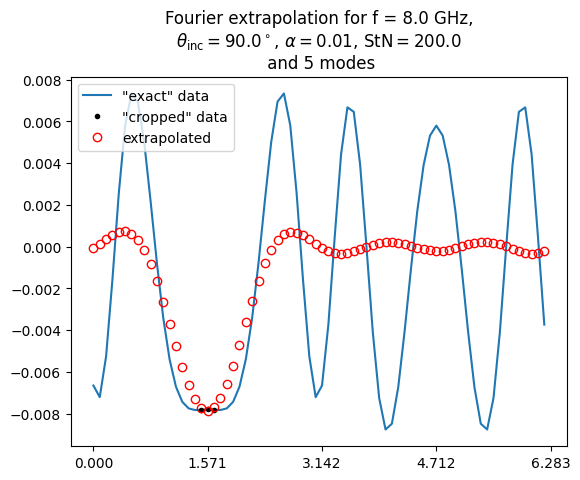

In [ ]:
plt.plot(theta_R,np.real(NF[:,e]),'-', label='"exact" data')
plt.plot(theta_R[r_ID[:,e]],np.real(NF[r_ID[:,e],e]),'.k', label='"cropped" data')
plt.plot(theta_R, np.real(u),'or',markerfacecolor='none', label='extrapolated')
plt.xticks(np.linspace(0,2*np.pi,5))
plt.xticklabels([])
plt.legend()
plt.title(f'Fourier extrapolation for f = {f/1E9 :.1f} GHz,\n$\\theta_\\mathrm{{inc}}={theta_E[e]*180/np.pi :.1f}^\\circ$, $\\alpha={alpha}$, $\\mathrm{{StN}}={StN}$\n and {FOURIER_MODES} modes')

# Nuclear norm 

Text(0.5, 1.0, 'singular values of the exact Near Field matrix')

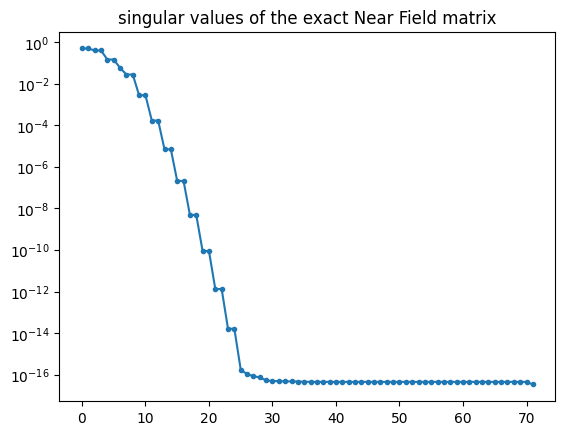

In [67]:
u, S, vh = np.linalg.svd(NF)
plt.semilogy(S,'.-')
plt.title('singular values of the exact Near Field matrix')

(144, 72)

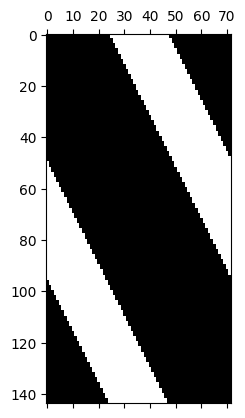

In [ ]:
mask = np.zeros_like(NF,dtype=np.int64)
for e in range(N_E):
    mask[r_ID[:,e],e] = 1
plt.spy(mask)


In [43]:
noise = err * np.linalg.norm(NF)*(np.random.rand(*NF.shape) + 1j*np.random.rand(*NF.shape))

NF_noisy = NF + noise
A_var = cp.Variable(NF.shape, complex=True)
objective = cp.Minimize(cp.normNuc(A_var))  # Nuclear norm of X
constraints = [cp.multiply(mask.astype('bool'), A_var) == cp.multiply(mask.astype('bool'), NF_noisy)]  # Observations constraint
problem = cp.Problem(objective, constraints)

problem.solver_stats
# Solve the problem

eps = 1E-6
problem.solve(solver=cp.SCS, verbose=True, eps_rel=eps, eps_abs=eps)

# Reconstructed matrix
NF_reconstructed = A_var.value


(CVXPY) Oct 24 11:28:40 AM: Your problem has 10368 variables, 10368 constraints, and 0 parameters.
(CVXPY) Oct 24 11:28:40 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 24 11:28:40 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 24 11:28:40 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Oct 24 11:28:40 AM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Oct 24 11:28:40 AM: Compiling problem (target solver=SCS).
(CVXPY) Oct 24 11:28:40 AM: Reduction chain: Complex2Real -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Oct 24 11:28:40 AM: Applying reduction Complex2Real
(CVXPY) Oct 24 11:28:40 AM: Applying reduction Dcp2Cone
(CVXPY) Oct 24 11:28:40 AM: Applying reduction CvxAttr2Constr
(CVXPY) Oct 24 11:28:40 AM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.7.1                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Oct 24 11:28:40 AM: Applying reduction SCS
(CVXPY) Oct 24 11:28:40 AM: Finished problem compilation (took 3.336e-01 seconds).
(CVXPY) Oct 24 11:28:40 AM: Invoking solver SCS  to obtain a solution.
/home/manuel/Documentos/extrapolation_algorithms/.env/lib/python3.9/site-packages/scs/__init__.py:83: UserWarning: Converting A to a CSC (compressed sparse column) matrix; may take a while.
  warn(


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
------------------------------------------------------------------
	       SCS v3.2.7 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 72792, constraints m: 114264
cones: 	  z: primal zero / dual free vars: 20736
	  s: psd vars: 93528, ssize: 1
settings: eps_abs: 1.0e-06, eps_rel: 1.0e-06, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 107640, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj

(CVXPY) Oct 24 11:29:02 AM: Problem status: optimal
(CVXPY) Oct 24 11:29:02 AM: Optimal value: 2.902e+00
(CVXPY) Oct 24 11:29:02 AM: Compilation took 3.336e-01 seconds
(CVXPY) Oct 24 11:29:02 AM: Solver (including time spent in interface) took 2.233e+01 seconds


   250| 5.01e-07  9.42e-07  7.23e-08  2.90e+00  4.26e+00  2.23e+01 
------------------------------------------------------------------
status:  solved
timings: total: 2.23e+01s = setup: 1.66e-01s + solve: 2.22e+01s
	 lin-sys: 9.49e-01s, cones: 2.07e+01s, accel: 1.10e-01s
------------------------------------------------------------------
objective = 2.902310
------------------------------------------------------------------
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


nuclear norm
 S: 2.2159224247964118
 S noisy:3.772207694569109
 S rec: 2.902313293611998


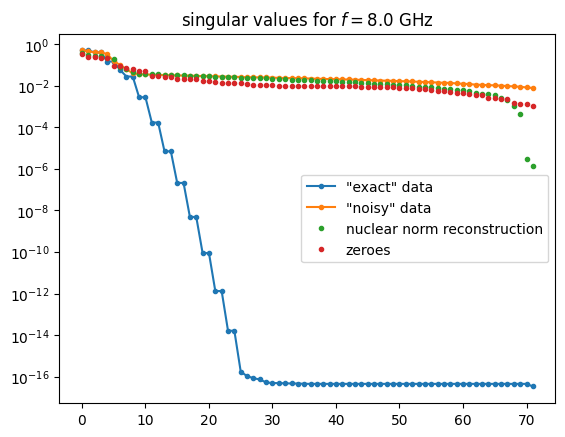

In [44]:
_, S_rec, _ = np.linalg.svd(NF_reconstructed)
_, S_noisy, _ = np.linalg.svd(NF_noisy)
_, S_zeros, _ = np.linalg.svd(NF_zeros)

plt.semilogy(S,'.-', label='"exact" data')
plt.semilogy(S_noisy,'.-', label='"noisy" data')
plt.semilogy(S_rec,'.', label='nuclear norm reconstruction')
plt.semilogy(S_zeros,'.', label='zeroes')

plt.title(f'singular values for $f={f/1E9 :.1f}$ GHz')
plt.legend()


def compute_nuclear_norm(A):
    _, s, _ = svd(A)
    return np.sum(s)

print( f'nuclear norm\n S: {compute_nuclear_norm(NF)}\n S noisy:{compute_nuclear_norm(NF_noisy)}\n S rec: {compute_nuclear_norm(NF_reconstructed)}')


Text(0.5, 1.0, 'difference')

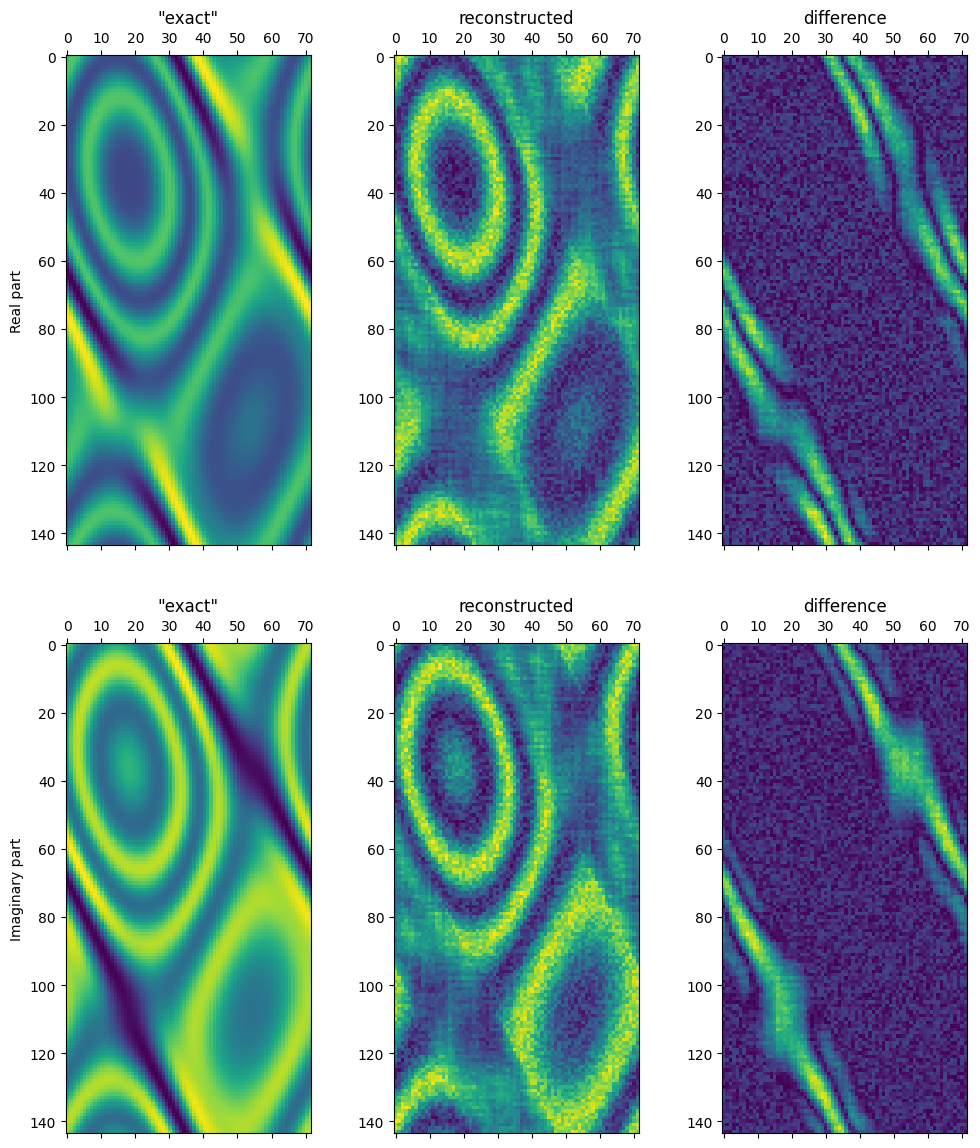

In [45]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(12,14))
ax[0,0].matshow(np.real(NF))
ax[0,0].set_ylabel('Real part')
ax[0,0].set_title('"exact"')
ax[0,1].matshow(np.real(NF_reconstructed))
ax[0,1].set_title('reconstructed')
ax[0,2].matshow(np.abs(np.real(NF - NF_reconstructed)))
ax[0,2].set_title('difference')
ax[1,0].matshow(np.imag(NF))
ax[1,0].set_title('"exact"')
ax[1,0].set_ylabel('Imaginary part')

ax[1,1].matshow(np.imag(NF_reconstructed))
ax[1,1].set_title('reconstructed')

ax[1,2].matshow(np.abs(np.imag(NF - NF_reconstructed)))
ax[1,2].set_title('difference')


Text(0.5, 1.0, '$|NF - NF_{reconstructed}|$,\n relative L2 distance $ 8.16e-01$')

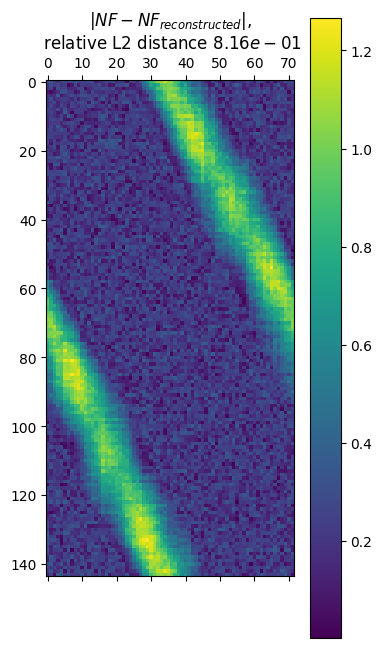

In [47]:
plt.matshow(np.abs(NF-NF_reconstructed)/np.max(np.abs(NF)))
l2_error = np.linalg.norm(NF - NF_reconstructed ) / np.linalg.norm(NF)
plt.colorbar()
plt.title(f'$|NF - NF_{{reconstructed}}|$,\n relative L2 distance ${l2_error : .2e}$')

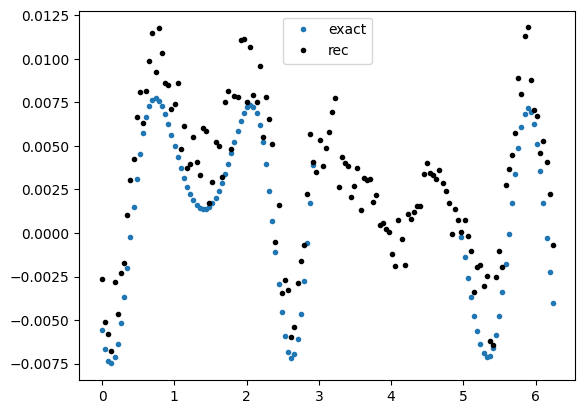

In [48]:
e = 9
plt.plot(theta_R[r_ID[:,e]] ,np.real(NF_cropped[r_ID[:,e],e]), '.', label='exact')
plt.plot(theta_R, np.real(NF_reconstructed[:,e]),'.k', label='rec')
plt.legend()


# LSM reconstructions

In [49]:
def LSM_indicator( z: float, k: float, NF: complex_array, r_R: float_array, alpha=0. ) -> float_array:
    u, s, _ = svd(NF, full_matrices=False)
    x = z[:,0]
    y = z[:,1]
    b = 1j/4*H_01(k*hypot(np.subtract.outer(x, r_R[:, 0]), np.subtract.outer(y, r_R[:, 1])))
    I = np.sum(s**2/(s**2 + alpha)**2*np.abs(np.matmul(b,np.conjugate(u)))**2,-1)
    return 1/np.sqrt(I)

In [50]:
L = 0.1
Nx = 200
x = np.linspace(-L, L, Nx)
y = np.linspace(-L, L, Nx)
X, Y = np.meshgrid(x, y)
z = np.column_stack([X.flatten(), Y.flatten()])
alpha_tikh = 1E-7
I_syn = LSM_indicator(z, k, NF, r_R,alpha=alpha_tikh).reshape(X.shape) 
I_recon = LSM_indicator(z, k, NF_reconstructed, r_R,alpha=alpha_tikh).reshape(X.shape)
I_zeros = LSM_indicator(z, k, NF_noisy, r_R,alpha=alpha_tikh).reshape(X.shape)

I_exact = ((X-sx)**2 + (Y-sy)**2) < R**2


Text(0.5, 0.98, 'Results with a threshold of l =  0.2')

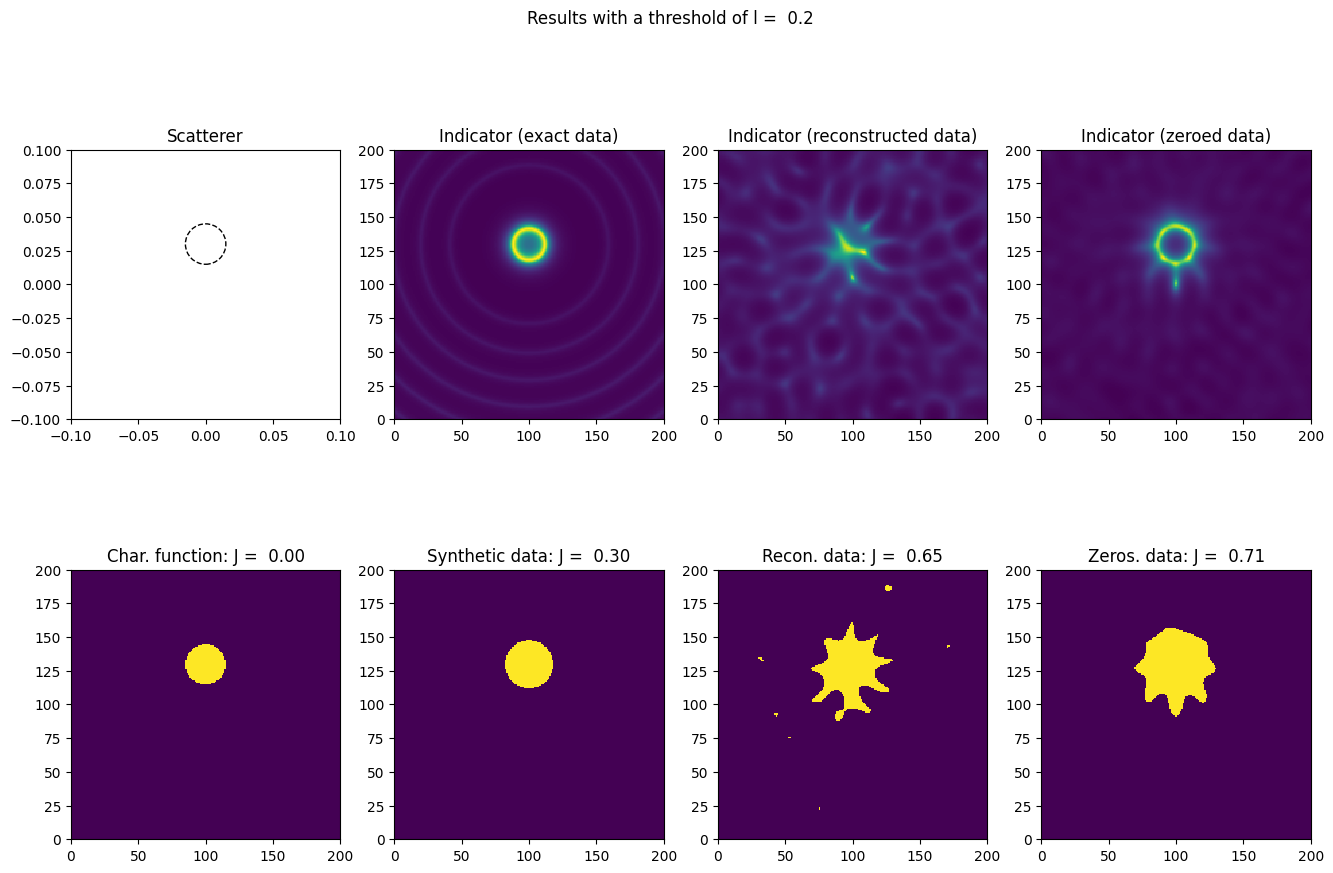

In [51]:

fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(16,10))


ax[0,0].add_patch(Circle(xy=s, radius=R, facecolor='none', edgecolor='black', linestyle='--'))
ax[0,0].axis('square')
ax[0,0].set_xlim([-L,L])
ax[0,0].set_ylim([-L,L])
ax[0,0].set_title('Scatterer')

ax[0,1].pcolormesh(I_syn)
ax[0,1].axis('square')
ax[0,1].set_title('Indicator (exact data)')

ax[0,2].pcolormesh(I_recon)
ax[0,2].axis('square')
ax[0,2].set_title('Indicator (reconstructed data)')

ax[0,3].pcolormesh(I_zeros)
ax[0,3].axis('square')
ax[0,3].set_title('Indicator (zeroed data)')



ax[1,0].pcolormesh(I_exact)
ax[1,0].axis('square')
ax[1,0].set_title(f'Char. function: J = {jaccard(I_exact.flatten(),I_exact.flatten()): .2f}')

l = 0.2

chr_syn = I_syn>l*np.max(I_syn)

ax[1,1].pcolormesh(chr_syn)
ax[1,1].axis('square')
ax[1,1].set_title(f'Synthetic data: J = {jaccard(I_exact.flatten(),chr_syn.flatten()): .2f}')

chr_recon = I_recon>l*np.max(I_recon)
ax[1,2].pcolormesh(chr_recon)
ax[1,2].axis('square')
ax[1,2].set_title(f'Recon. data: J = {jaccard(I_exact.flatten(),chr_recon.flatten()): .2f}')

chr_zeros = I_zeros>l*np.max(I_zeros)
ax[1,3].pcolormesh(chr_zeros)
ax[1,3].axis('square')
ax[1,3].set_title(f'Zeros. data: J = {jaccard(I_exact.flatten(),chr_zeros.flatten()): .2f}')


fig.suptitle(f'Results with a threshold of l = {l : .1f}')

# Dependency on the threshold

In [52]:
def make_threshold_plot(Ind, I_exact, N):
    thresholds = np.linspace(0,1,N)
    errors = np.zeros_like(thresholds)
    for n,l in enumerate(thresholds):
        chr = Ind>l*np.max(Ind)
        errors[n] = jaccard(I_exact.flatten(), chr.flatten())
    return thresholds, errors

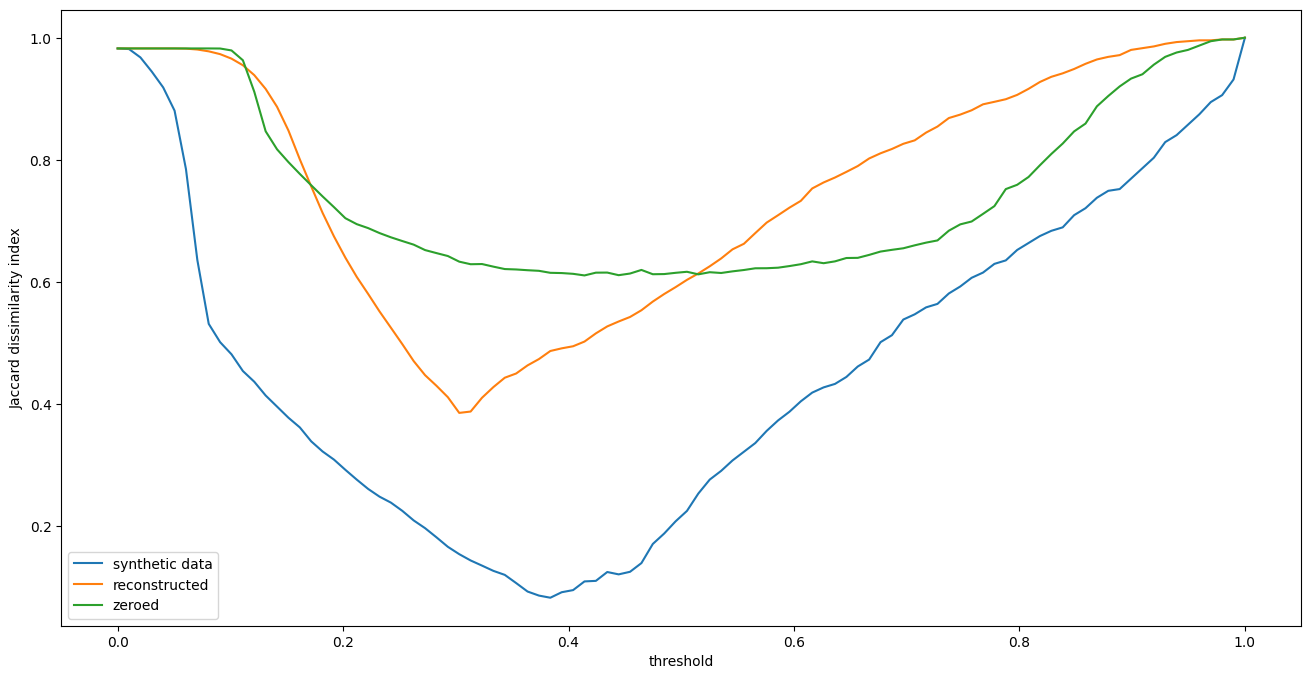

In [53]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(*make_threshold_plot(I_syn,I_exact,100), label='synthetic data')
ax.plot(*make_threshold_plot(I_recon,I_exact,100), label='reconstructed')
ax.plot(*make_threshold_plot(I_zeros,I_exact,100), label='zeroed')

ax.set_xlabel('threshold')
ax.set_ylabel('Jaccard dissimilarity index')
plt.legend()

In [54]:
from pathlib import Path
folder = Path("./Fresnel_Data")
filename = Path("dielTM_dec8f.txt")
file_route = folder / filename

fresnel_data = np.loadtxt(fname=file_route, skiprows=10)
N_F = 8
shape = (N_F, N_M, N_E)
U_tot = (fresnel_data[:,3] - 1j*fresnel_data[:,4]).reshape(shape, order="F")
U_inc = (fresnel_data[:,5] - 1j*fresnel_data[:,6]).reshape(shape, order="F")
U_sc = U_inc - U_tot


ValueError: cannot reshape array of size 14112 into shape (8,98,72)

In [ ]:
NF_Fresnel = np.zeros([N_F, N_R, N_E], dtype=np.complex128)
for f_ID in range(N_F):
    for e_ID in range(N_E):
        NF_Fresnel[f_ID,r_ID[:,e_ID],e_ID] = U_sc[f_ID,:,e_ID]

# The other approach

In [26]:
noise = err * np.linalg.norm(NF)*(np.random.rand(*NF.shape) + 1j*np.random.rand(*NF.shape))

NF_noisy = NF + noise

lbd = 1E-3

A_var = cp.Variable(NF.shape, complex=True)
objective = cp.Minimize(lbd*cp.normNuc(A_var) + cp.norm(NF_noisy[mask.astype('bool')] - A_var[mask.astype('bool')],'fro')**2)  # Nuclear norm of X
problem = cp.Problem(objective, constraints)

eps = 1E-6
# Solve the problem
problem.solve(solver=cp.SCS, verbose=True, eps_rel=eps, eps_abs=eps)

# Reconstructed matrix
NF_reconstructed = A_var.value

(CVXPY) Oct 15 11:29:41 AM: Your problem has 5184 variables, 2592 constraints, and 0 parameters.
(CVXPY) Oct 15 11:29:41 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 15 11:29:41 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 15 11:29:41 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Oct 15 11:29:41 AM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Oct 15 11:29:41 AM: Compiling problem (target solver=SCS).
(CVXPY) Oct 15 11:29:41 AM: Reduction chain: Complex2Real -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Oct 15 11:29:41 AM: Applying reduction Complex2Real
(CVXPY) Oct 15 11:29:41 AM: Applying reduction Dcp2Cone
(CVXPY) Oct 15 11:29:41 AM: Applying reduction CvxAttr2Constr
(CVXPY) Oct 15 11:29:41 AM: Applying reduction ConeMatrixStuffing
(CVXPY) Oct 15 11:29:41 AM: Applying re

                                     CVXPY                                     
                                     v1.7.1                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
------------------------------------------------------------------
	       SCS v3.2.7 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 25201, constraints m: 35677
cones: 	  z: primal zero / dual free vars: 5184
	  q: soc vars: 7057, qsize: 176

/home/manuel/Documentos/extrapolation_algorithms/.env/lib/python3.9/site-packages/scs/__init__.py:113: UserWarning: Converting P to a CSC (compressed sparse column) matrix; may take a while.
  warn(


   250| 3.39e-06  2.09e-06  1.69e-07  1.04e-03  1.00e-01  3.54e+00 


(CVXPY) Oct 15 11:29:46 AM: Problem status: optimal
(CVXPY) Oct 15 11:29:46 AM: Optimal value: 1.040e-03
(CVXPY) Oct 15 11:29:46 AM: Compilation took 9.676e-02 seconds
(CVXPY) Oct 15 11:29:46 AM: Solver (including time spent in interface) took 5.526e+00 seconds


   400| 8.57e-07  8.78e-07  4.15e-08  1.04e-03  1.00e-01  5.52e+00 
------------------------------------------------------------------
status:  solved
timings: total: 5.52e+00s = setup: 5.32e-02s + solve: 5.47e+00s
	 lin-sys: 3.95e-01s, cones: 4.86e+00s, accel: 6.23e-02s
------------------------------------------------------------------
objective = 0.001040
------------------------------------------------------------------
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


nuclear norm
 S: 1.0021717562910126
 S noisy:1.1501129293147059
 S rec: 1.0312108412684766


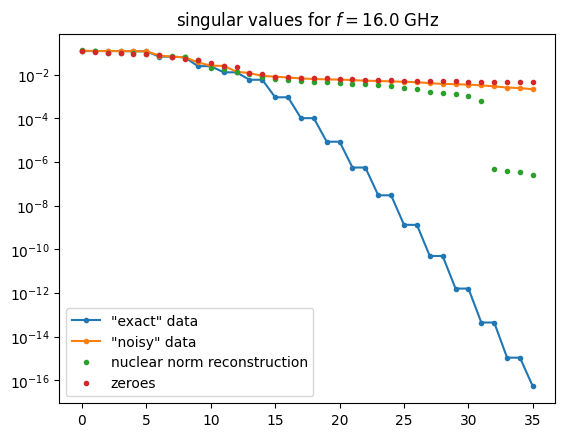

In [27]:
_, S_rec, _ = np.linalg.svd(NF_reconstructed)
_, S_noisy, _ = np.linalg.svd(NF_noisy)
_, S_zeros, _ = np.linalg.svd(NF_zeros)

plt.semilogy(S,'.-', label='"exact" data')
plt.semilogy(S_noisy,'.-', label='"noisy" data')
plt.semilogy(S_rec,'.', label='nuclear norm reconstruction')
plt.semilogy(S_zeros,'.', label='zeroes')

plt.title(f'singular values for $f={f/1E9 :.1f}$ GHz')
plt.legend()


def compute_nuclear_norm(A):
    _, s, _ = svd(A)
    return np.sum(s)

print( f'nuclear norm\n S: {compute_nuclear_norm(NF)}\n S noisy:{compute_nuclear_norm(NF_noisy)}\n S rec: {compute_nuclear_norm(NF_reconstructed)}')

Text(0.5, 1.0, 'difference')

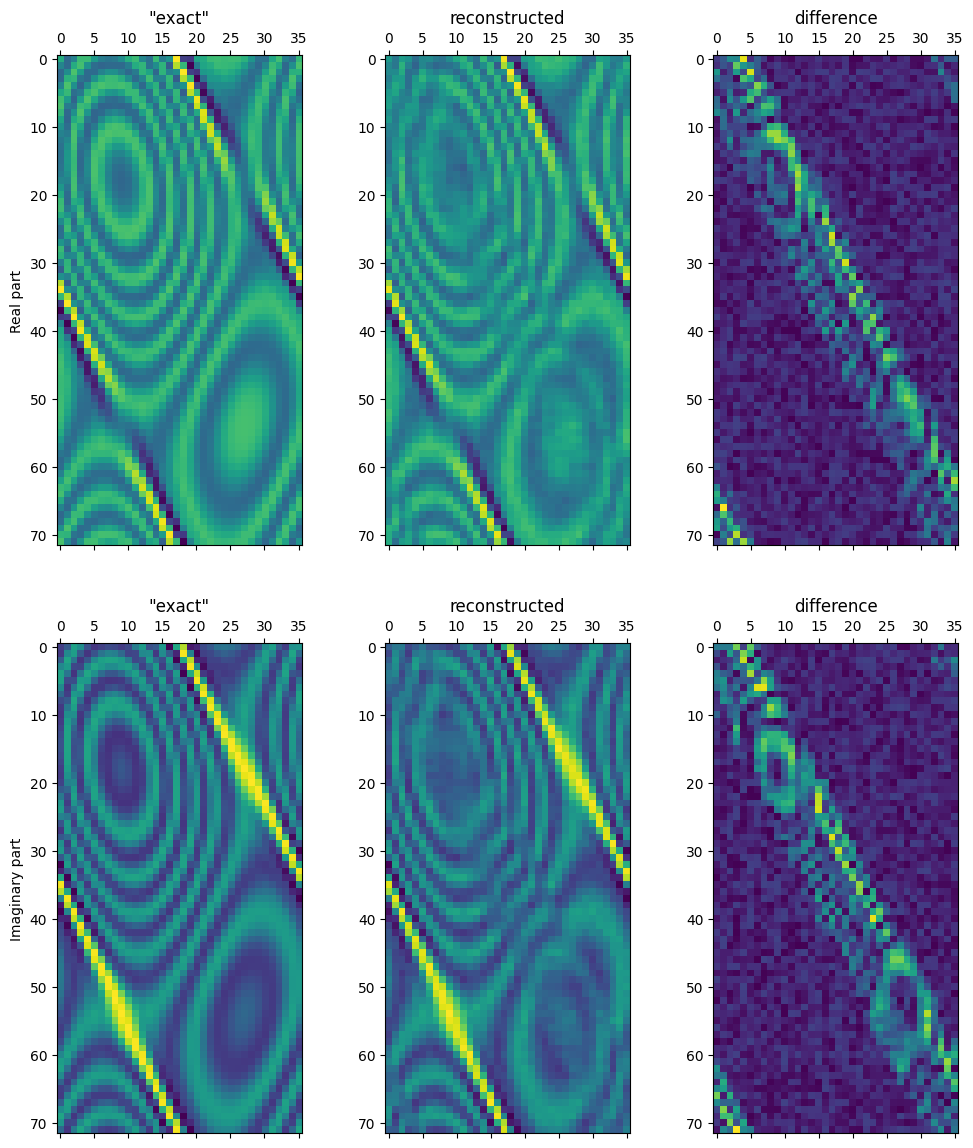

In [28]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(12,14))
ax[0,0].matshow(np.real(NF))
ax[0,0].set_ylabel('Real part')
ax[0,0].set_title('"exact"')
ax[0,1].matshow(np.real(NF_reconstructed))
ax[0,1].set_title('reconstructed')
ax[0,2].matshow(np.abs(np.real(NF - NF_reconstructed)))
ax[0,2].set_title('difference')
ax[1,0].matshow(np.imag(NF))
ax[1,0].set_title('"exact"')
ax[1,0].set_ylabel('Imaginary part')

ax[1,1].matshow(np.imag(NF_reconstructed))
ax[1,1].set_title('reconstructed')

ax[1,2].matshow(np.abs(np.imag(NF - NF_reconstructed)))
ax[1,2].set_title('difference')


In [29]:
L = 0.1
Nx = 200
x = np.linspace(-L, L, Nx)
y = np.linspace(-L, L, Nx)
X, Y = np.meshgrid(x, y)
z = np.column_stack([X.flatten(), Y.flatten()])
alpha_tikh = 1E-5
I_syn = LSM_indicator(z, k, NF, r_R,alpha=alpha_tikh).reshape(X.shape) 
I_recon = LSM_indicator(z, k, NF_reconstructed, r_R,alpha=alpha_tikh).reshape(X.shape)
I_zeros = LSM_indicator(z, k, NF_zeros, r_R,alpha=alpha_tikh).reshape(X.shape)

I_exact = ((X-sx)**2 + (Y-sy)**2) < R**2


Text(0.5, 0.98, 'Results with a threshold of l =  0.4')

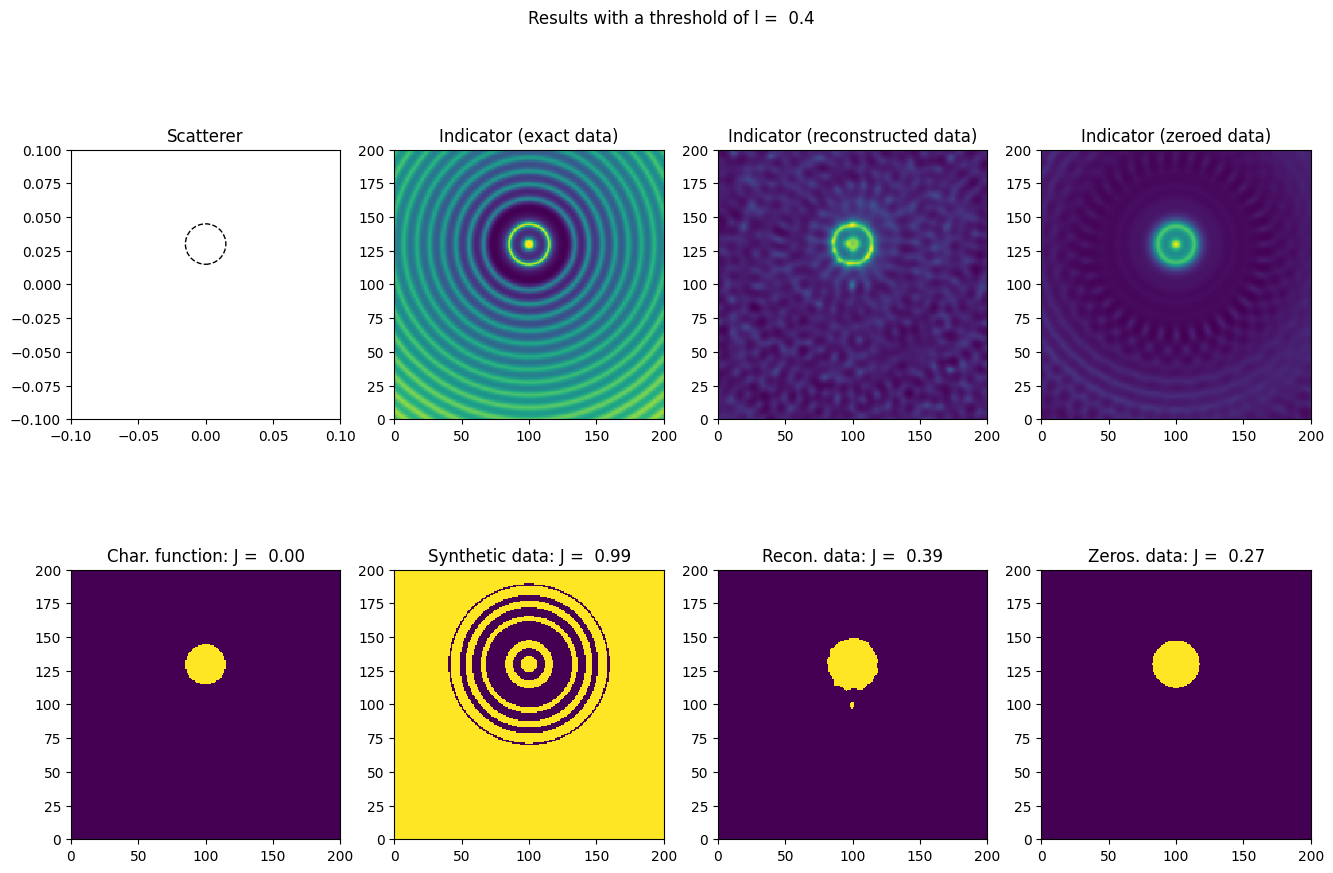

In [30]:
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(16,10))


ax[0,0].add_patch(Circle(xy=s, radius=R, facecolor='none', edgecolor='black', linestyle='--'))
ax[0,0].axis('square')
ax[0,0].set_xlim([-L,L])
ax[0,0].set_ylim([-L,L])
ax[0,0].set_title('Scatterer')

ax[0,1].pcolormesh(I_syn)
ax[0,1].axis('square')
ax[0,1].set_title('Indicator (exact data)')

ax[0,2].pcolormesh(I_recon)
ax[0,2].axis('square')
ax[0,2].set_title('Indicator (reconstructed data)')

ax[0,3].pcolormesh(I_zeros)
ax[0,3].axis('square')
ax[0,3].set_title('Indicator (zeroed data)')



ax[1,0].pcolormesh(I_exact)
ax[1,0].axis('square')
ax[1,0].set_title(f'Char. function: J = {jaccard(I_exact.flatten(),I_exact.flatten()): .2f}')

l = 0.4

chr_syn = I_syn>l*np.max(I_syn)

ax[1,1].pcolormesh(chr_syn)
ax[1,1].axis('square')
ax[1,1].set_title(f'Synthetic data: J = {jaccard(I_exact.flatten(),chr_syn.flatten()): .2f}')

chr_recon = I_recon>l*np.max(I_recon)
ax[1,2].pcolormesh(chr_recon)
ax[1,2].axis('square')
ax[1,2].set_title(f'Recon. data: J = {jaccard(I_exact.flatten(),chr_recon.flatten()): .2f}')

chr_zeros = I_zeros>l*np.max(I_zeros)
ax[1,3].pcolormesh(chr_zeros)
ax[1,3].axis('square')
ax[1,3].set_title(f'Zeros. data: J = {jaccard(I_exact.flatten(),chr_zeros.flatten()): .2f}')


fig.suptitle(f'Results with a threshold of l = {l : .1f}')

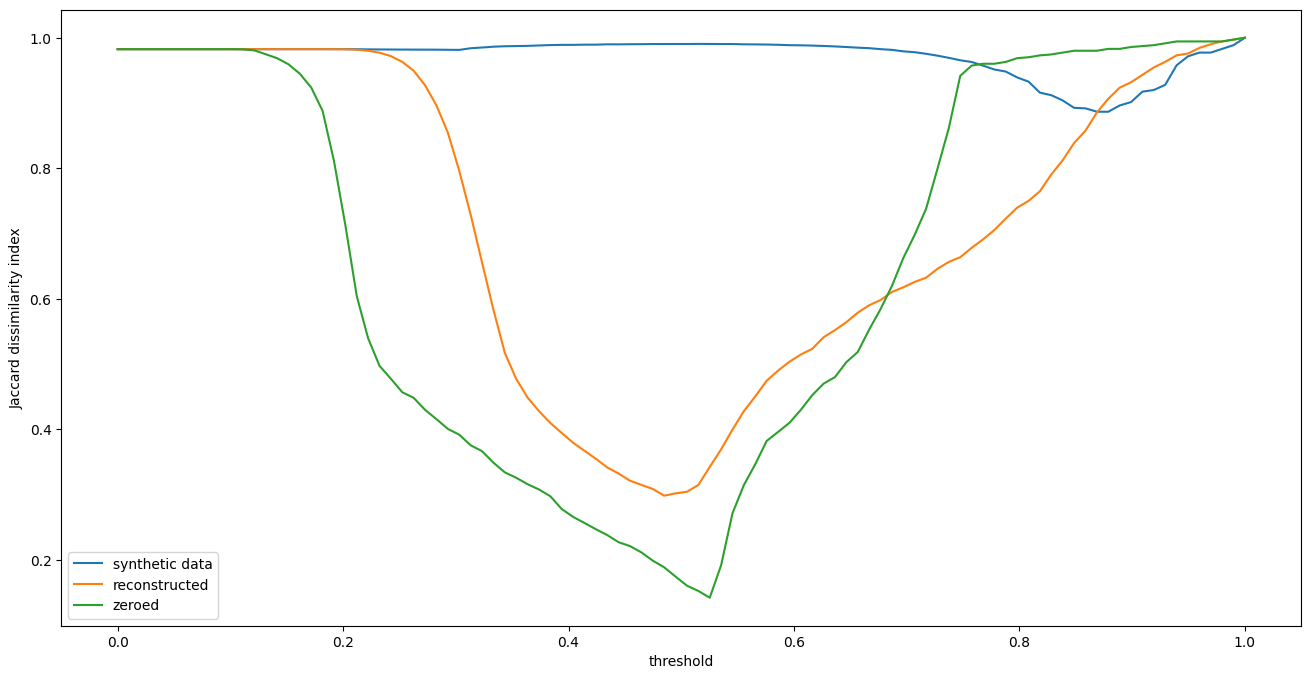

In [31]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(*make_threshold_plot(I_syn,I_exact,100), label='synthetic data')
ax.plot(*make_threshold_plot(I_recon,I_exact,100), label='reconstructed')
ax.plot(*make_threshold_plot(I_zeros,I_exact,100), label='zeroed')

ax.set_xlabel('threshold')
ax.set_ylabel('Jaccard dissimilarity index')
plt.legend()

# NGSOLVE

In [302]:
from netgen import geom2d
from ngsolve import Mesh, H1, BilinearForm, SymbolicBFI, grad, pml, GridFunction, LinearForm, SymbolicLFI
from ngsolve import specialcf, Integrate, BND, pml
import ngsolve as ns


In [303]:
theta_r = np.linspace(0, 2*np.pi, N_R, endpoint=False)
x_hat = np.column_stack([np.cos(theta_r), np.sin(theta_r)])

theta_E = np.linspace(0, 2*np.pi, N_E, endpoint= False) + np.pi
d_inc = np.column_stack([np.cos(theta_E), np.sin(theta_E)])


wavelength = c / f

d_PML = wavelength
R_PML = max(0.15,wavelength)
print(f'{R_PML=}, {f=} {wavelength=}, {d_PML=}')

R_PML=0.15, f=8000000000.0 wavelength=0.03747405725, d_PML=0.03747405725


In [304]:

def three_scatterers():
    geo = geom2d.SplineGeometry()
    ##scatterers:
    centers = [(0.05,  0.0),
            (0.00,  0.02),
            (-0.02, -0.02)]
    radiae = [ 0.015, 0.015, 0.015]

    centers = [(0.045,  0.045),
            (0.0,  -0.045)]
    radiae = [ 0.015, 0.015]



    centers = [(0.045,  0.045),
            (0.0,  -0.045),
            (-0.045, 0.00)]
    radiae = [ 0.015, 0.015, 0.01]




    for (x_c,y_c), R in zip(centers, radiae):
        geo.AddCircle(c=(x_c,y_c), r=R, bc="Gamma", leftdomain=3, rightdomain=1)
        


    geo.AddCircle(c=(0,0),r=R_PML, bc="Gamma_PML", leftdomain=1, rightdomain=2)
    geo.AddCircle(c=(0,0),r=R_PML+d_PML, bc="Gamma_inf", leftdomain=2, rightdomain=0)
    geo.SetMaterial(1,'background')
    geo.SetMaterial(2,'PML')
    geo.SetMaterial(3,'scatterer')
    Omega = Mesh(geo.GenerateMesh(maxh=wavelength/8))

    Omega.Curve(3)

    # the alpha probably will need to be adjusted
    Omega.SetPML(pml.Radial(rad=R_PML,alpha=0.5j,origin=(0,0)),"PML")
    

    eps_r = Omega.MaterialCF({ "scatterer" : 3, "background" : 1, "PML" : 1}) 

    return Omega, eps_r


def U_shaped_scatterer():
    geo = geom2d.SplineGeometry()
    #scatterers:
    l = 0.080
    h = 0.050
    e = 0.005

    pnts = [(  -l/2, -h/2  ),
            (   l/2, -h/2  ),
            (   l/2, -h/2+e),
            (-l/2+e, -h/2+e),
            (-l/2+e,  h/2-e),
            (   l/2,  h/2-e),
            (   l/2,  h/2  ),
            (  -l/2,  h/2  )]
    
    vertices = [ geo.AppendPoint(*pnt) for pnt in pnts ]

    for n in range(len(vertices)):
        geo.Append(["line", vertices[n-1] , vertices[n] ], bc="Gamma", leftdomain=3, rightdomain=1)


    geo.AddCircle(c=(0,0),r=R_PML, bc="Gamma_PML", leftdomain=1, rightdomain=2)
    geo.AddCircle(c=(0,0),r=R_PML+d_PML, bc="Gamma_inf", leftdomain=2, rightdomain=0)
    geo.SetMaterial(1,'background')
    geo.SetMaterial(2,'PML')
    geo.SetMaterial(3,'scatterer')
    Omega = Mesh(geo.GenerateMesh(maxh=wavelength/8))

    Omega.Curve(3)

    # the alpha probably will need to be adjusted
    Omega.SetPML(pml.Radial(rad=R_PML,alpha=0.5j,origin=(0,0)),"PML")
    

    eps_r = Omega.MaterialCF({ "scatterer" : 3, "background" : 1, "PML" : 1}) 

    return Omega, eps_r, pnts

In [305]:
from enum import Enum, auto

class Scatteter(Enum):
    THREE_SCATTERERS = auto()
    U = auto()

scatterer = Scatteter.U

## UPGRADE TO MATCH for Python > 3.10

if scatterer ==  Scatteter.U:
    Omega, eps_r, pnts = U_shaped_scatterer()
if scatterer == Scatteter.THREE_SCATTERERS:
    Omega, eps_r = three_scatterers()



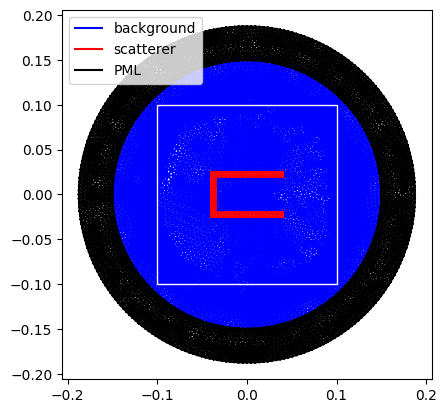

In [306]:
def plot_mesh(Omega):
    points = np.array([v.point for v in Omega.vertices])
    tri = np.array([ [v.nr for v in T.vertices] for T in Omega.Elements() ])
    for label, color  in zip(["background", "scatterer", "PML"], ['-b','-r', '-k']):
        tr = np.array([ [v.nr for v in T.vertices] for T in Omega.Elements() if T.mat == label ])
        plt.triplot(points[:,0], points[:,1],tr, color,  label=label)

    # tri_bg = np.array([ [v.nr for v in T.vertices] for T in Omega.Elements() if T.mat == "background" ])
    # tri_sc = np.array([ [v.nr for v in T.vertices] for T in Omega.Elements() if T.mat == "scatterer" ])
    # tri_PML = np.array([ [v.nr for v in T.vertices] for T in Omega.Elements() if T.mat == "PML" ])
    # plt.triplot(points[:,0], points[:,1],tri, label='background')
    # plt.triplot(points[:,0], points[:,1],tri_sc, "-r", label='scatterer')
    # plt.triplot(points[:,0], points[:,1],tri_PML, "-k", label="PML")
    plt.legend()
    plt.axis('square')
    return tri, plt.gca()
tri, ax = plot_mesh(Omega)
ax.add_patch(Rectangle(xy=(-L,-L), width=2*L, height=2*L, facecolor='none', edgecolor='w'))



In [307]:
def compute_near_field_from_solution(u_FEM, polynomial_order=4): ##!! NEEDS HANKEL FUNCTIONS IN NGSOLVE
    ff_u = np.zeros(N_R, dtype=np.complex128)
    ff_du = np.zeros(N_R, dtype=np.complex128)
    for i in range(N_R):
        d_r = x_hat[i,:]
        E = ns.exp(-1J* k *( ns.x*d_r[0]+ ns.y*d_r[1]))
        dphi = -1j*k*( d_r[0]*N[0] + d_r[1]*N[1] ) * E
        H_out = H1(Omega, order=polynomial_order, complex=True, definedon=Omega.Materials("background"))
        trace_E = GridFunction(H_out)
        trace_E.vec[:] = 0
        trace_E.Set(E, BND, definedon=Omega.Boundaries("scatterer"))
        ff_u[i] = np.exp(1j*k*R_R)/np.sqrt(R_R)*Integrate( dphi * u_FEM, Omega, order= polynomial_order+1, definedon=Omega.Boundaries("scatterer"))
        ff_du[i] = np.exp(1j*k*R_R)/np.sqrt(R_R)*Integrate(grad(trace_E)*grad(u_FEM)-k**2*trace_E*u_FEM, Omega, order= polynomial_order+1, definedon= Omega.Materials("background"))

    return np.exp(1j*np.pi/4)/np.sqrt(8*np.pi*k)*(ff_u + ff_du)


# from numpy.fft import fft
from numpy import trapezoid
def fft(t,y,N):
    # t goes from 0 to 2*np.pi so c returns the frecuency w as in cos(wt)
    # instead of f in cos( 2 pi f t)
    c = np.zeros(2*N+1,dtype=complex)
    for n in range(-N,N+1):
        c[n+N] = 1/np.sqrt(2*np.pi)*trapezoid(y*np.exp(-1j*n*t), t)
    return c

from scipy.special import j0, y0

def H_01(x):
    return j0(x) + 1j*y0(x)

def near_field_from_Hankel_expansion(u_FEM, Omega, R_PML, k): #THIS IS WRONG its Hn not H0 
    Nt = 100
    t = np.linspace(0,2*np.pi, Nt) 
    x, y = R_PML*np.cos(t), R_PML*np.sin(t)
    u_R = u_FEM(Omega(x,y))[:,0]
    M = 50
    c = fft(t=t, y=u_R, N=M) # someday I should understand how the numpy version works 
    theta_r = np.linspace(0, 2*np.pi, N_R, endpoint=False)
    # x_r, y_r = R_R*np.cos(theta_r), R_R*np.sin(theta_r)
    u_meas = np.zeros_like(theta_r, dtype=np.complex128)
    for n in range(-M,M+1):
        u_meas += 1/np.sqrt(2*np.pi)*c[n+M]*hankel1(n,k*R_R)/hankel1(n,k*R_PML)*np.exp(1j*n*theta_r)

    return u_meas



In [308]:
polynomial_order = 4

H = H1(Omega, order = polynomial_order, complex=True)
u = H.TrialFunction()
v = H.TestFunction()

a = BilinearForm(H)
a += SymbolicBFI(grad(u)*grad(v) - eps_r*k**2*u*v)
a += SymbolicBFI(-1j*k*u*v,definedon=Omega.Boundaries("Gamma_inf"))


a.Assemble()
A_inv = a.mat.Inverse()

NF = np.zeros((N_R, N_E), dtype=np.complex128)

for e in range(N_E):
    print(f'{f=} {e=}')
    d = d_inc[e,:]
    
    # phi_0 = np.angle(U_inc[f_ID,(36+2*e)//72,e]/np.exp( 1j*k*(R_R)))
    # u_inc_ns = U_inc[f_ID,(36+2*e)%72,e]/np.exp( 1j*k*(R_R))*ns.exp( 1j*k*( d[0]*ns.x + d[1]*ns.y) ) # fitted plane wave 
    u_inc_ns = ns.exp( 1j*k*( d[0]*ns.x + d[1]*ns.y) )  #plane wave with (1 + 0j) amplitude at origin
    l = LinearForm(H)
    l += SymbolicLFI((eps_r-1)*k**2*u_inc_ns * v)
    l.Assemble()
    u_FEM = GridFunction(H)
    u_FEM.vec.data = A_inv * l.vec
    #FF[f,:,e] = compute_far_field(u_FEM)
    NF[:,e] = near_field_from_Hankel_expansion(u_FEM, Omega, R_PML, k) 

f=8000000000.0 e=0
f=8000000000.0 e=1
f=8000000000.0 e=2
f=8000000000.0 e=3
f=8000000000.0 e=4
f=8000000000.0 e=5
f=8000000000.0 e=6
f=8000000000.0 e=7
f=8000000000.0 e=8
f=8000000000.0 e=9
f=8000000000.0 e=10
f=8000000000.0 e=11
f=8000000000.0 e=12
f=8000000000.0 e=13
f=8000000000.0 e=14
f=8000000000.0 e=15
f=8000000000.0 e=16
f=8000000000.0 e=17
f=8000000000.0 e=18
f=8000000000.0 e=19
f=8000000000.0 e=20
f=8000000000.0 e=21
f=8000000000.0 e=22
f=8000000000.0 e=23
f=8000000000.0 e=24
f=8000000000.0 e=25
f=8000000000.0 e=26
f=8000000000.0 e=27
f=8000000000.0 e=28
f=8000000000.0 e=29
f=8000000000.0 e=30
f=8000000000.0 e=31
f=8000000000.0 e=32
f=8000000000.0 e=33
f=8000000000.0 e=34
f=8000000000.0 e=35
f=8000000000.0 e=36
f=8000000000.0 e=37
f=8000000000.0 e=38
f=8000000000.0 e=39
f=8000000000.0 e=40
f=8000000000.0 e=41
f=8000000000.0 e=42
f=8000000000.0 e=43
f=8000000000.0 e=44
f=8000000000.0 e=45
f=8000000000.0 e=46
f=8000000000.0 e=47
f=8000000000.0 e=48
f=8000000000.0 e=49
f=80000000

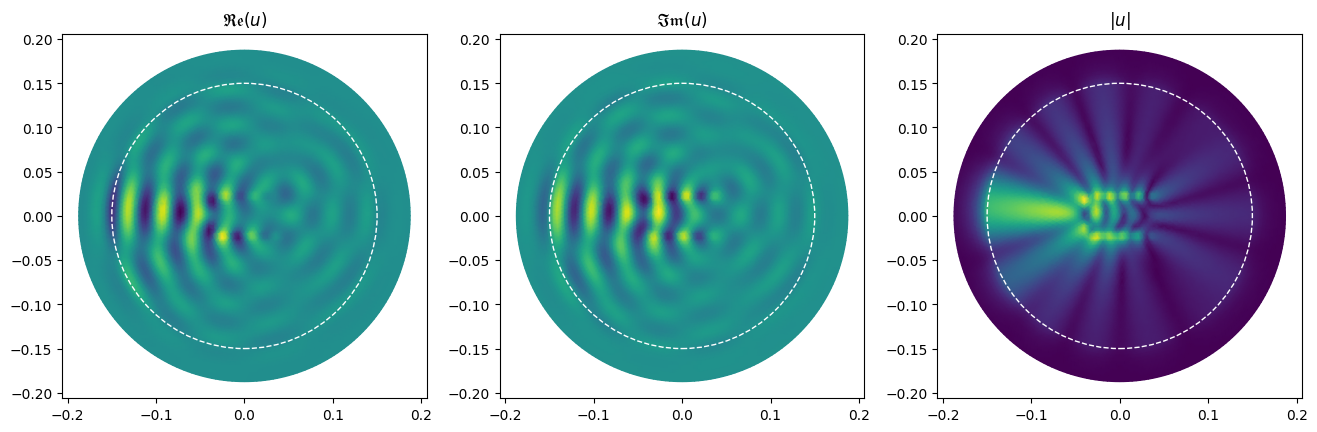

In [309]:
from matplotlib.tri import Triangulation
fig, ax = plt.subplots(ncols=3, nrows=1,figsize=(16,5))
def plot_solution(Omega, u_FEM):
    points = np.array([v.point for v in Omega.vertices])
    tri_bg = np.array([ [v.nr for v in T.vertices] for T in Omega.Elements() ])
    tri_sc = np.array([ [v.nr for v in T.vertices] for T in Omega.Elements() if T.mat == "scatterer" ])
    tri_PML = np.array([ [v.nr for v in T.vertices] for T in Omega.Elements() if T.mat == "PML" ])
    
    tri = Triangulation(points[:,0], points[:,1], triangles=tri_bg)
    
    z_values = u_FEM(Omega(tri.x, tri.y))
    
    ax[0].tripcolor(tri,np.real(z_values)[:,0], shading="gouraud")
    ax[1].tripcolor(tri,np.imag(z_values)[:,0], shading="gouraud")
    ax[2].tripcolor(tri,np.abs(z_values)[:,0], shading="gouraud")
    ax[0].add_patch(Circle(xy=(0,0), radius=R_PML, linestyle='--', facecolor='none', edgecolor='w'))
    ax[1].add_patch(Circle(xy=(0,0), radius=R_PML, linestyle='--', facecolor='none', edgecolor='w'))
    ax[2].add_patch(Circle(xy=(0,0), radius=R_PML, linestyle='--', facecolor='none', edgecolor='w'))
    ax[0].axis('square')
    ax[1].axis('square')
    ax[2].axis('square') 
    ax[0].set_title('$\\mathfrak{{Re}}(u)$')
    ax[1].set_title('$\\mathfrak{{Im}}(u)$')
    ax[2].set_title('$|u|$')
       
    return 

plot_solution(Omega,u_FEM)


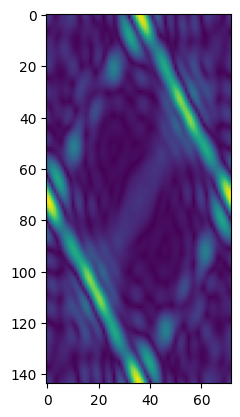

In [310]:
plt.imshow(np.abs(NF))

In [311]:
NF_zeros = np.zeros_like(NF)
for e in range(N_E):
    NF_zeros[r_ID[:,e],e] = NF[r_ID[:,e],e]
    

In [312]:
A_var = cp.Variable(NF.shape, complex=True)
objective = cp.Minimize(cp.normNuc(A_var))  # Nuclear norm of X
constraints = [cp.multiply(mask.astype('bool'), A_var) == cp.multiply(mask.astype('bool'), NF)]  # Observations constraint
problem = cp.Problem(objective, constraints)

problem.solver_stats
# Solve the problem

eps = 1E-6
problem.solve(solver=cp.SCS, verbose=True, eps_rel=eps, eps_abs=eps)

# Reconstructed matrix
NF_reconstructed = A_var.value


(CVXPY) Oct 15 03:36:51 PM: Your problem has 10368 variables, 10368 constraints, and 0 parameters.
(CVXPY) Oct 15 03:36:51 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 15 03:36:51 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 15 03:36:51 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Oct 15 03:36:51 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Oct 15 03:36:51 PM: Compiling problem (target solver=SCS).
(CVXPY) Oct 15 03:36:51 PM: Reduction chain: Complex2Real -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Oct 15 03:36:51 PM: Applying reduction Complex2Real
(CVXPY) Oct 15 03:36:51 PM: Applying reduction Dcp2Cone
(CVXPY) Oct 15 03:36:51 PM: Applying reduction CvxAttr2Constr
(CVXPY) Oct 15 03:36:51 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Oct 15 03:36:51 PM: Applying 

                                     CVXPY                                     
                                     v1.7.1                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
------------------------------------------------------------------
	       SCS v3.2.7 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 72792, constraints m: 114264
cones: 	  z: primal zero / dual free vars: 20736
	  s: psd vars: 93528, ssize: 

(CVXPY) Oct 15 03:45:52 PM: Problem status: optimal
(CVXPY) Oct 15 03:45:52 PM: Optimal value: 6.954e+01
(CVXPY) Oct 15 03:45:52 PM: Compilation took 1.914e-01 seconds
(CVXPY) Oct 15 03:45:52 PM: Solver (including time spent in interface) took 5.412e+02 seconds


  6125| 2.68e-06  1.66e-07  8.63e-09  6.95e+01  1.00e+00  5.41e+02 
------------------------------------------------------------------
status:  solved
timings: total: 5.41e+02s = setup: 1.18e-01s + solve: 5.41e+02s
	 lin-sys: 2.35e+01s, cones: 5.06e+02s, accel: 2.73e+00s
------------------------------------------------------------------
objective = 69.541727
------------------------------------------------------------------
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


Text(0.5, 1.0, 'reconstructed')

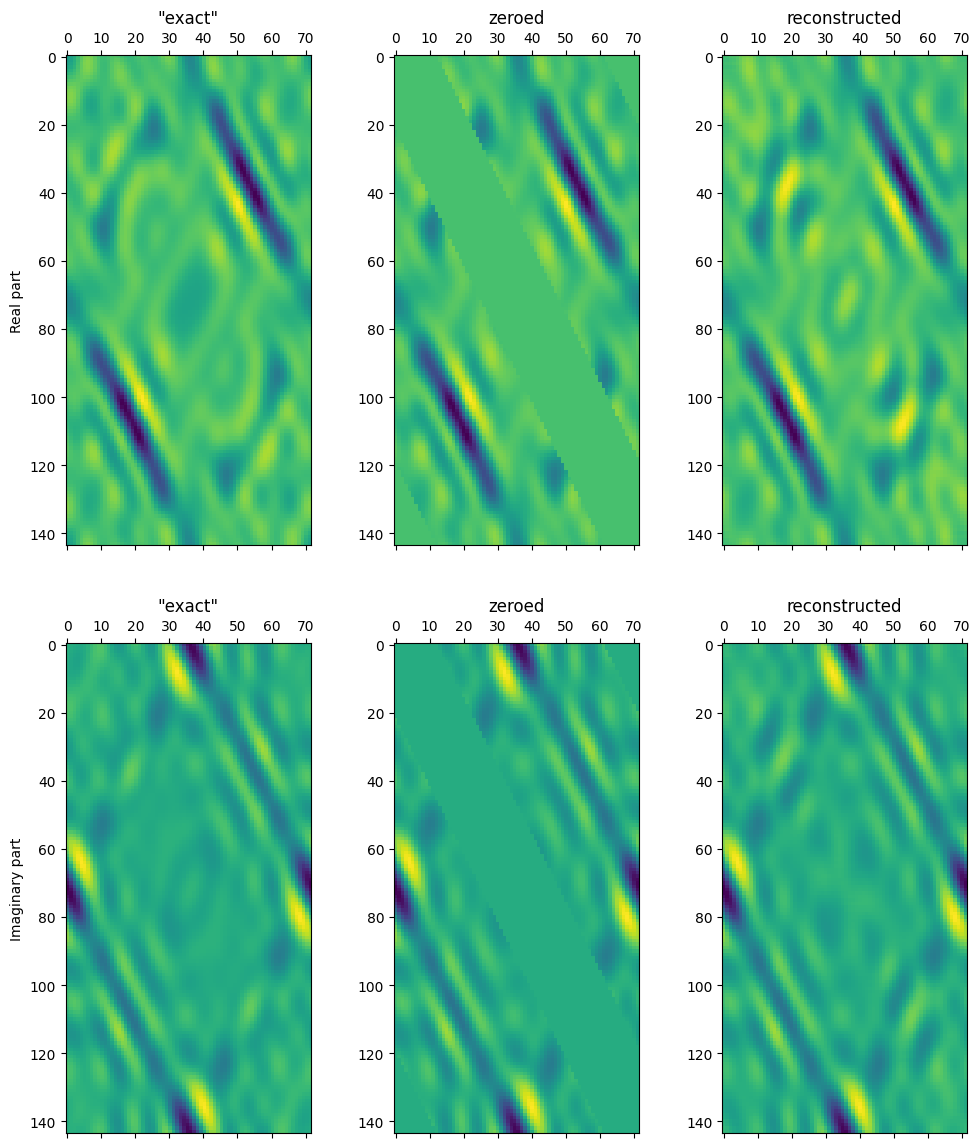

In [313]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(12,14))
ax[0,0].matshow(np.real(NF))
ax[0,0].set_ylabel('Real part')
ax[0,0].set_title('"exact"')
ax[0,1].matshow(np.real(NF_zeros))
ax[0,1].set_title('zeroed')
ax[0,2].matshow(np.real(NF_reconstructed))
ax[0,2].set_title('reconstructed')
ax[1,0].matshow(np.imag(NF))
ax[1,0].set_title('"exact"')
ax[1,0].set_ylabel('Imaginary part')

ax[1,1].matshow(np.imag(NF_zeros))
ax[1,1].set_title('zeroed')

ax[1,2].matshow(np.imag(NF_reconstructed))
ax[1,2].set_title('reconstructed')

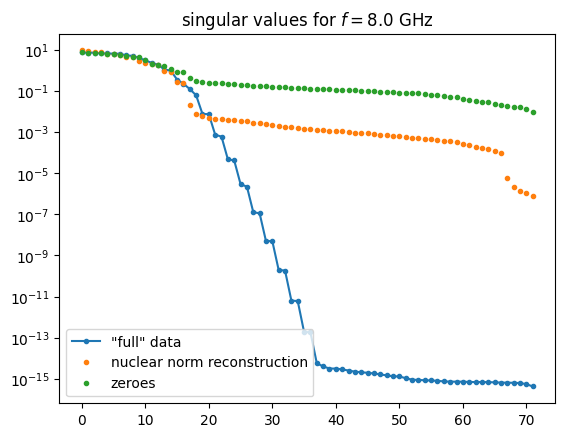

In [314]:
_, S_full, _ = np.linalg.svd(NF)
_, S_recon, _ = np.linalg.svd(NF_reconstructed)
_, S_zeros, _ = np.linalg.svd(NF_zeros)

plt.semilogy(S_full,'.-', label='"full" data')
plt.semilogy(S_recon,'.', label='nuclear norm reconstruction')
plt.semilogy(S_zeros,'.', label='zeroes')

plt.title(f'singular values for $f={f/1E9 :.1f}$ GHz')
plt.legend()




In [315]:
u, s, vh = np.linalg.svd(NF_reconstructed)

NF_rr = np.zeros_like(NF_reconstructed)

rank = 11
for n in range(rank):
    NF_rr += np.outer(u[:,n], vh[n,:])*s[n]


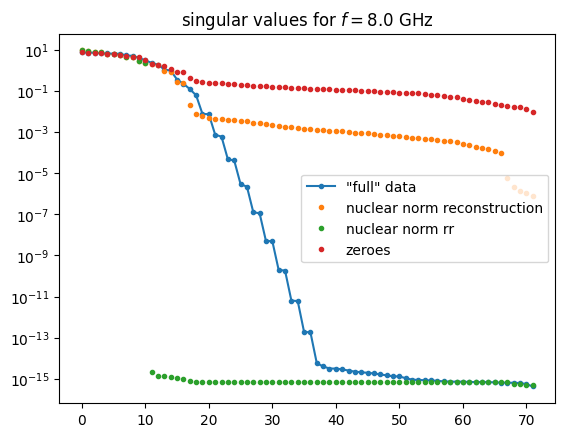

In [316]:
u, s, vh = np.linalg.svd(NF_rr)


plt.semilogy(S_full,'.-', label='"full" data')
plt.semilogy(S_recon,'.', label='nuclear norm reconstruction')
plt.semilogy(s,'.', label='nuclear norm rr')
plt.semilogy(S_zeros,'.', label='zeroes')

plt.title(f'singular values for $f={f/1E9 :.1f}$ GHz')
plt.legend()



In [323]:
L = 0.1
Nx = 200
x = np.linspace(-L, L, Nx)
y = np.linspace(-L, L, Nx)
X, Y = np.meshgrid(x, y)
z = np.column_stack([X.flatten(), Y.flatten()])
alpha_tikh = 0.
I_syn = LSM_indicator(z, k, NF, r_R,alpha=alpha_tikh).reshape(X.shape) 
I_zeros = LSM_indicator(z, k, NF_zeros, r_R,alpha=alpha_tikh).reshape(X.shape)
I_recon = LSM_indicator(z, k, NF_reconstructed, r_R,alpha=alpha_tikh).reshape(X.shape)
# I_rr = LSM_indicator(z, k, NF_rr, r_R,alpha=alpha_tikh).reshape(X.shape)


Text(0.5, 0.98, 'NG-solve generated data: f = 8.0 GHz, $\\alpha_\\mathrm{tikhonov} = 0.0$')

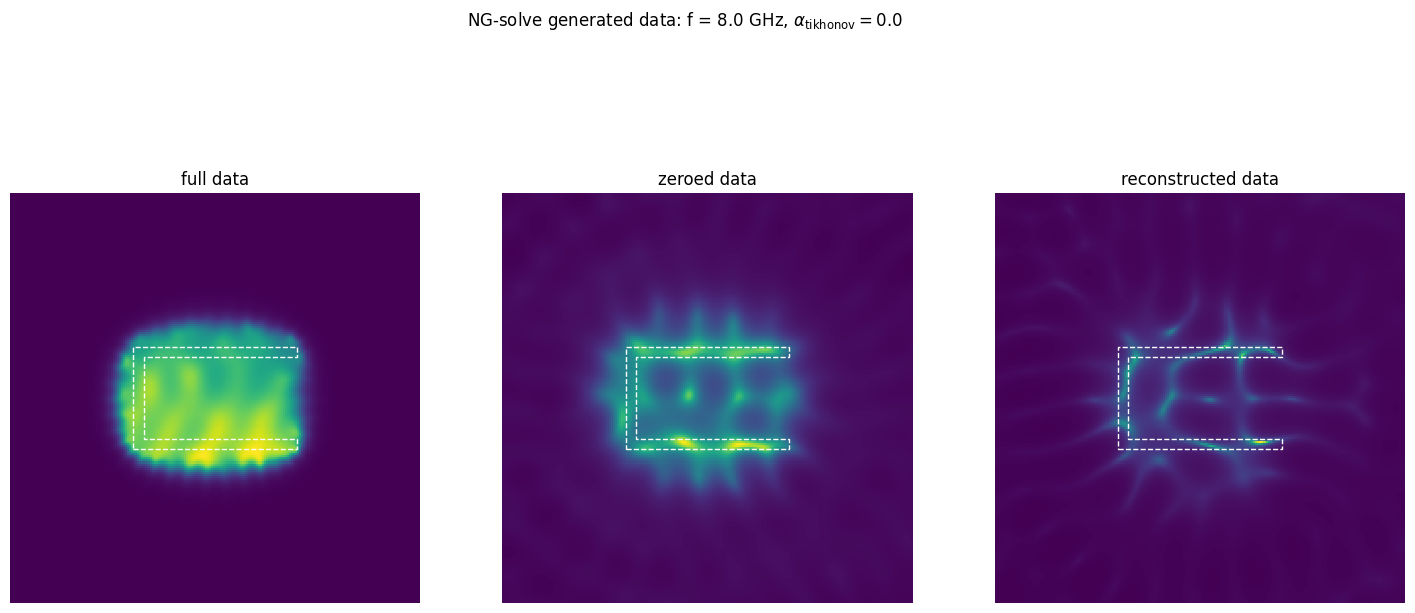

In [324]:
kwargs = {'facecolor': 'none', 
          'edgecolor': 'w',
          'linestyle': '--'}
def add_patches(ax,scatterer):
    if scatterer ==  Scatteter.U:
        ax.add_patch(Polygon(np.array(pnts), **kwargs))
    if scatterer == Scatteter.THREE_SCATTERERS:
        for (x_c, y_c), R in zip(centers, radiae):
            ax.add_patch(Circle(xy=(x_c, y_c), radius=R, **kwargs))




fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,8))
ax[0].pcolormesh(X,Y,I_syn)
add_patches(ax[0],scatterer)



ax[0].axis('square')
ax[0].axis('off')
ax[0].set_title('full data')

ax[1].pcolormesh(X,Y,I_zeros)
add_patches(ax[1],scatterer)
ax[1].axis('square')
ax[1].axis('off')
ax[1].set_title('zeroed data')


ax[2].pcolormesh(X,Y,I_recon)
add_patches(ax[2],scatterer)
ax[2].axis('square')
ax[2].axis('off')
ax[2].set_title('reconstructed data')



fig.suptitle(f'NG-solve generated data: f = {f/1E9:.1f} GHz, $\\alpha_\\mathrm{{tikhonov}} = {alpha_tikh}$')
